In [1]:
import pandas as pd
import numpy as np


The Project Workflow can be broken into steps:

1. Data Loading from Yelp Open DataSet and Data Preprocessing
2. Topic Modeling and Sentiment Analysis - Done simultaneously
3. Linear Regression of Topic Sentiments on Review Rating


## Data Loading

First step is to load the dataset. We will load businesses with over 100 reviews

In [2]:
def get_business_dataset(review_threshold):
    #Load restaurant businesses with over a threshold amount of reviews
    business_json_path = 'yelp_academic_dataset_business.json'
    
    df_b = pd.read_json(business_json_path, lines = True)
    df_b = df_b.loc[df_b['review_count'] > review_threshold]
    df_b = df_b.loc[df_b['categories'].str.contains('Restaurants') == True]

    return df_b


In [3]:
review_businesses = get_business_dataset(100)
review_businesses.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."
13,ufCxltuh56FF4-ZFZ6cVhg,Sister Honey's,247 E Michigan St,Orlando,FL,32806,28.513265,-81.374707,4.5,135,1,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, American (New), Bakeries, Dessert...","{'Tuesday': '11:0-18:0', 'Wednesday': '11:0-18..."
29,jGennaZUr2MsJyRhijNBfA,Legal Sea Foods,1 Harborside Dr,Boston,MA,02128,42.363442,-71.025781,3.5,856,1,"{'NoiseLevel': 'u'average'', 'BikeParking': 'F...","Sandwiches, Food, Restaurants, Breakfast & Bru...","{'Monday': '6:0-21:0', 'Tuesday': '6:0-21:0', ..."
41,NRPemqVb4qpWFF0Avq_6OQ,Eurasia Sushi Bar & Seafood,"7101 W Hwy 71, Ste C-13",Austin,TX,78735,30.234533,-97.877262,4.5,395,1,"{'Ambience': '{'touristy': False, 'hipster': F...","Bars, Nightlife, Cocktail Bars, Seafood, Resta...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ..."


Next step is to get all reviews corresponding to the businesses we loaded in `review_businesses`

In [7]:
def get_review_dataset(review_json_path, businesses):
    
    size = 100000
    review = pd.read_json(review_json_path, lines=True,
                          dtype={'review_id':str,'user_id':str,
                                 'business_id':str,'stars':int,
                                 'date':str,'text':str,'useful':int,
                                 'funny':int,'cool':int},
                          chunksize=size)
    chunk_list = []
    for chunk_review in review:
        # Drop columns that aren't needed
        chunk_review = chunk_review.drop(['review_id','useful','funny','cool'], axis=1)
        # Renaming column name to avoid conflict with business overall star rating
        chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
        # Inner merge with edited business file so only reviews related to the business remain
        chunk_merged = pd.merge(businesses, chunk_review, on='business_id', how='inner')
        # Show feedback on progress
        chunk_list.append(chunk_merged)
    # After trimming down the review file, concatenate all relevant data back to one dataframe
    df_merged = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
    return df_merged


In [8]:
review_json_path = 'yelp_academic_dataset_review.json'
review_df = get_review_dataset(review_json_path, review_businesses)
review_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,user_id,review_stars,text,date
0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",24gb1QBBEl2xHtVeTzDsCQ,4,Elephant's contacted me the same day I posted ...,2012-07-16 05:04:05
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",AsDPajAdVBsXydg60AIsdw,5,I'm not usually a fan of airport food. I usual...,2015-04-28 21:11:10
2,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",Eypq5gLLjCapBVVnMw_MyA,4,"If one must have breakfast at the airport, per...",2015-11-18 18:50:05
3,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",X568BojbbH6cAxqXU5zLwA,5,"Reasonably priced, tasty local joint. Lots of ...",2011-11-30 20:15:41
4,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",gQMsoHpjmzBmBQkkefrLXw,5,"Other than my own store, this is my go-to airp...",2016-08-12 23:47:28


## Topic Modeling and Sentiment Analysis

Now we are ready for the NLP portion of this project. The first step is to create a word bank for each topic created. Here, we have created three topics: environment, service and price. Each of these topics contain keywords that are specific to the topic. Keywords should be added carefully. It is also good if the topics have roughly the same amount of keywords.

In [9]:
environment_keyword = ['clean','dirty','spotless','sanitary','shiny','messy','environment','atmosphere','vibe','mood','ambience', 'decoration',
                       'relax', 'architecture']
service_keyword = ['service','customer','rude','mean','rushed','friendly', 'patient', 'server', 'waiter', 'waitress','timely',
                   'slow','fast','quickly','forever','refund','tip', 'wait']
price_keyword = ['expensive','cheap','price','cost','dollar','dollars', 'money', 'pricy','ripoff','affordable', 'value', 'discount', 'bill']


The next step is to create a Ratios table. First we count  up all occurances of all the words in the word bank. Then we divide this by the sum of occurances of all terms to get the percentage of the total occurances of each word. This statistic is similar to TF-IDF, where we will weigh the occurance of each term by this frequency statistic.

In [10]:
term_dictionary = dict()
for keyword in (environment_keyword + service_keyword + price_keyword):
    term_dictionary[keyword] = sum(review_df.text.str.count(keyword))

total_term_count = sum(term_dictionary.values())

ratio_dictionary = dict()
for keyword in (environment_keyword + service_keyword + price_keyword):
    ratio_dictionary[keyword] = term_dictionary[keyword]/total_term_count

review_sample = review_df[1:1000]

sentence = 'The atmosphere and service are great, but the waiter is a bit slow.'
Ratios = pd.DataFrame.from_dict(ratio_dictionary, orient = 'index')
Ratios = Ratios.rename(columns = {0: 'Ratios'})
Env = Ratios.index.isin(environment_keyword)
Ratios['Env'] = Env
Serv = Ratios.index.isin(service_keyword)
Ratios['Serv'] = Serv
Pr = Ratios.index.isin(price_keyword)
Ratios['Pr'] = Pr


In [11]:
Ratios.head(10)

,Ratios,Env,Serv,Pr
clean,0.023259,True,False,False
dirty,0.005477,True,False,False
spotless,0.000301,True,False,False
sanitary,0.000381,True,False,False
shiny,0.000238,True,False,False
messy,0.001551,True,False,False
environment,0.005662,True,False,False
atmosphere,0.040739,True,False,False
vibe,0.011120,True,False,False
mood,0.004482,True,False,False


Finally we are at the topic modeling stage.  

In [12]:
def topic_modeler(reviews, Ratios):
    #This function creates analyzes each sentence in the reviews, and assigns a topic distribution to them.
    #The sentiment of the sentence will also be analyzed using Flair package
    from flair.models import TextClassifier
    from flair.data import Sentence
    import re
    
    #For checking Flair datatype
    def isfloat(value):
      try:
        float(value)
        return True
      except ValueError:
        return False
    sia = TextClassifier.load('en-sentiment')
    
    #Topic Categorizer to be applied on each review in the dataframe.
    #Return dataframe with each row containing a sentence, sentence topic distribution, and sentence sentiment score
    def topic_categorizer(paragraph):
        #Split paragraph into sentences
        sentence_list = nltk.tokenize.sent_tokenize(paragraph)
        
        #Create Weight list for each topic - we have three topics
        Environment_List = []
        Service_List = []
        Price_List = []

        #Go through each sentence
        sentence_analyzed = []
        sentence_topics = []
        sentence_sentiment = []
        for sentence in sentence_list:
            
            #Create dictionary of all counts of keywords in this sentence
            count_dict = dict()
            for keyword in list(Ratios.index):
                counts = sentence.count(keyword)
                if counts > 0:
                    count_dict[keyword] = counts
            
            #Append this count information to your Term-Ratios Dataframe
            #Calculate the Weighted Ratio of each term
             
            topic_list = []
            if count_dict:
                #Pull the TF-IDF Ratios from the Ratios table. This will weigh each matching word accordingly
                sent_df = Ratios.join(pd.DataFrame.from_dict(count_dict, orient = 'index'), how = 'inner')
                sent_df = sent_df.rename(columns = {0: 'Counts'})
                Ratio_sum = ((1/sent_df['Ratios'])*sent_df['Counts']).sum()
                sent_df['Weighted_Ratio'] = (1/(sent_df['Ratios'])*sent_df['Counts'])/Ratio_sum
                
                #Aggregate the terms into the topics specified
                sent_gb = sent_df.groupby(['Env','Serv','Pr'],as_index = False)['Weighted_Ratio'].sum()
                
                #Append these to the original lists
                if sent_gb['Env'].any() == True:
                    topic_list.append(sent_gb[sent_gb['Env'] == True].reset_index().iloc[0]['Weighted_Ratio'])
                else:
                    topic_list.append(0)
                if sent_gb['Serv'].any() == True:
                    topic_list.append(sent_gb[sent_gb['Serv'] == True].reset_index().iloc[0]['Weighted_Ratio'])
                else:
                    topic_list.append(0)
                if sent_gb['Pr'].any() == True:
                    topic_list.append(sent_gb[sent_gb['Pr'] == True].reset_index().iloc[0]['Weighted_Ratio'])
                else:
                    topic_list.append(0)

                #Calculate the Sentiment of the Sentence
                sent = Sentence(sentence)
                sia.predict(sent)
                score = str(sent.labels[0])
                score = score.replace('(',' ').replace(')',' ')
                number = [float(s) for s in score.split() if isfloat(s) is True]
                
                if "POSITIVE" in score:
                    flair_score =  number[0]
                elif "NEGATIVE" in score:
                    flair_score = -number[0]

            #Append all processed data to the lists.
            if topic_list:
                sentence_topics.append(topic_list)
                sentence_analyzed.append(sentence)
                sentence_sentiment.append(flair_score)
                
        return sentence_analyzed, sentence_topics, sentence_sentiment
    
    review_topic = pd.DataFrame()
    reviews['Sentence'], reviews['Sentence Topics'], reviews['Sentence Sentiment'] = zip(*reviews.text.apply(topic_categorizer))

    return reviews


In [17]:
import nltk

review_sample = review_df[0:200000]
reviews_list = np.array_split(review_sample,100)
flair_list = []
for i in range (0, len(reviews_list)):
    flair_review = topic_modeler(reviews_list[i], Ratios)
    flair_list.append(flair_review)
    

reviews_filtered = pd.concat(flair_list)


2021-12-31 20:16:48,561 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt
2021-12-31 20:18:00,385 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:19:12,873 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:20:24,623 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:21:35,808 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:22:43,845 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:23:56,104 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:25:10,514 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:26:19,183 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:27:32,084 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:28:49,549 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:30:05,963 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:31:05,029 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:32:22,512 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:33:41,377 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:34:57,457 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:36:05,379 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:37:16,118 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:38:34,329 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:39:52,792 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:41:07,869 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:42:15,617 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:43:25,318 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:44:36,473 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:45:53,068 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:47:04,941 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:48:15,300 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:49:27,264 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:50:35,000 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:51:57,128 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:53:07,470 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:54:18,106 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:55:31,286 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:56:45,950 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:58:01,568 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 20:59:18,670 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:00:27,453 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:01:45,039 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:03:00,934 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:04:05,780 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:05:21,471 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:06:37,037 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:07:56,583 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:09:12,084 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:10:23,837 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:11:37,385 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:12:55,671 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:14:06,318 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:15:21,437 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:16:31,164 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:17:40,124 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:18:56,461 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:20:10,547 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:21:18,339 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:22:39,736 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:23:47,515 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:24:55,330 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:26:10,259 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:27:21,380 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:28:27,830 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:29:41,788 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:30:59,896 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:32:19,819 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:33:29,970 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:34:41,964 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:35:57,215 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:37:10,072 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:38:14,247 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:39:32,963 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:40:50,208 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:42:04,187 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:43:15,307 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:44:25,751 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:45:42,830 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:46:58,691 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:48:12,413 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:49:23,616 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:50:32,685 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:51:48,365 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:53:05,237 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:54:17,468 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:55:32,730 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:56:45,687 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:57:51,072 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 21:59:08,820 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:00:20,639 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:01:33,388 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:02:44,431 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:04:01,022 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:05:17,707 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:06:31,865 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:07:44,113 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:08:59,788 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:10:14,151 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:11:19,814 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:12:32,422 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:13:49,510 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:15:00,884 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:16:14,587 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


2021-12-31 22:17:24,319 loading file C:\Users\kenhu\.flair\models\sentiment-en-mix-distillbert_4.pt


C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
C:\Users\kenhu\anaconda3\envs\gpu4\lib\site-packages\pandas\core\common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [18]:
reviews_filtered.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,attributes,categories,hours,user_id,review_stars,text,date,Sentence,Sentence Topics,Sentence Sentiment
0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",24gb1QBBEl2xHtVeTzDsCQ,4,Elephant's contacted me the same day I posted ...,2012-07-16 05:04:05,[],[],[]
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",AsDPajAdVBsXydg60AIsdw,5,I'm not usually a fan of airport food. I usual...,2015-04-28 21:11:10,"[However, I had no choice this past weekend on...","[[0, 1.0, 0]]",[-0.6821]
2,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",Eypq5gLLjCapBVVnMw_MyA,4,"If one must have breakfast at the airport, per...",2015-11-18 18:50:05,"[If one must have breakfast at the airport, pe...","[[0, 1.0, 0]]",[0.6861]
3,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",X568BojbbH6cAxqXU5zLwA,5,"Reasonably priced, tasty local joint. Lots of ...",2011-11-30 20:15:41,"[Reasonably priced, tasty local joint., Beers ...","[[0, 0, 1.0], [0, 0, 1.0]]","[0.9962, -0.8692]"
4,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",gQMsoHpjmzBmBQkkefrLXw,5,"Other than my own store, this is my go-to airp...",2016-08-12 23:47:28,"[Fresh food, lots of allergy-friendly options,...","[[0, 1.0, 0]]",[0.9964]


We need to a little more processing. Firstly, each row currently corresponds to a review. However, it needs to correspond to a sentence. So we user pd.explode on the Sentence sentences to accomplish this.

In [19]:
def process_split_df(reviews):
    review_names = reviews[['business_id','user_id','name','review_stars']]

    reviews_split = reviews[['business_id','user_id', 'Sentence', 'Sentence Topics', 'Sentence Sentiment']]

    reviews_split = reviews_split.set_index(['business_id','user_id']).apply(pd.Series.explode).reset_index()
    reviews_split = reviews_split[~reviews_split['Sentence Topics'].isnull()]

    reviews_processed = pd.merge(review_names, reviews_split, on = ['business_id','user_id'], how = 'inner')
    return reviews_processed


In [24]:
reviews_split = process_split_df(reviews_filtered)
reviews_split.head()

,business_id,user_id,name,review_stars,Sentence,Sentence Topics,Sentence Sentiment
0,tCbdrRPZA0oiIYSmHG3J0w,AsDPajAdVBsXydg60AIsdw,Flying Elephants at PDX,5,"However, I had no choice this past weekend on ...","[0, 1.0, 0]",-0.6821
1,tCbdrRPZA0oiIYSmHG3J0w,Eypq5gLLjCapBVVnMw_MyA,Flying Elephants at PDX,4,"If one must have breakfast at the airport, per...","[0, 1.0, 0]",0.6861
2,tCbdrRPZA0oiIYSmHG3J0w,X568BojbbH6cAxqXU5zLwA,Flying Elephants at PDX,5,"Reasonably priced, tasty local joint.","[0, 0, 1.0]",0.9962
3,tCbdrRPZA0oiIYSmHG3J0w,X568BojbbH6cAxqXU5zLwA,Flying Elephants at PDX,5,Beers for pretty cheap compared to a typical r...,"[0, 0, 1.0]",-0.8692
4,tCbdrRPZA0oiIYSmHG3J0w,gQMsoHpjmzBmBQkkefrLXw,Flying Elephants at PDX,5,"Fresh food, lots of allergy-friendly options, ...","[0, 1.0, 0]",0.9964


Also need to scale the Sentiment Analysis score. Currently it is from -1 to 1, and it is also skewed towards the ends, since it is a classifier algorithm. I will use Quantile Transformer to scale it to a linear variable from 0 to 1, which is more suitable for further modeling.

In [21]:
def quantile_transform(df):
    
    from sklearn.preprocessing import QuantileTransformer
    reviews_y = df[['Sentence Sentiment']]
    
    qt = QuantileTransformer()
    qt2 = QuantileTransformer()
    X_1 = reviews_y.loc[reviews_y['Sentence Sentiment'] >= 0]
    X_2 = reviews_y.loc[reviews_y['Sentence Sentiment'] < 0]
    
    X_1['flair_quantile_custom'] = qt.fit_transform(X_1[['Sentence Sentiment']])/2 + 0.5
    X_2['flair_quantile_custom'] = qt2.fit_transform(X_2[['Sentence Sentiment']])/2
    
    X = X_1.append(X_2)
    X.sort_index(inplace = True)
    
    return X['flair_quantile_custom']


In [25]:
reviews_split['Sentence Sentiment'] = quantile_transform(reviews_split)

reviews_split.head()

<ipython-input-21-b6cff6273ffd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1['flair_quantile_custom'] = qt.fit_transform(X_1[['Sentence Sentiment']])/2 + 0.5
<ipython-input-21-b6cff6273ffd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2['flair_quantile_custom'] = qt2.fit_transform(X_2[['Sentence Sentiment']])/2


,business_id,user_id,name,review_stars,Sentence,Sentence Topics,Sentence Sentiment
0,tCbdrRPZA0oiIYSmHG3J0w,AsDPajAdVBsXydg60AIsdw,Flying Elephants at PDX,5,"However, I had no choice this past weekend on ...","[0, 1.0, 0]",0.470877
1,tCbdrRPZA0oiIYSmHG3J0w,Eypq5gLLjCapBVVnMw_MyA,Flying Elephants at PDX,4,"If one must have breakfast at the airport, per...","[0, 1.0, 0]",0.520816
2,tCbdrRPZA0oiIYSmHG3J0w,X568BojbbH6cAxqXU5zLwA,Flying Elephants at PDX,5,"Reasonably priced, tasty local joint.","[0, 0, 1.0]",0.807057
3,tCbdrRPZA0oiIYSmHG3J0w,X568BojbbH6cAxqXU5zLwA,Flying Elephants at PDX,5,Beers for pretty cheap compared to a typical r...,"[0, 0, 1.0]",0.425541
4,tCbdrRPZA0oiIYSmHG3J0w,gQMsoHpjmzBmBQkkefrLXw,Flying Elephants at PDX,5,"Fresh food, lots of allergy-friendly options, ...","[0, 1.0, 0]",0.813814


## Linear Regression

The next step is to prepare the data for regression. This can be done in various ways, but for our study, we care about what is happening at the restaurant level, so aggregation will be done to average topic sentiments and review ratings across each restaurant. The function `data_aggregator` goes through this process.

In [26]:
def data_aggregator(reviews_split):
    
    #First split the Sentence Topics column into columns for your topics. In my case: Env, Serv, Pr
    def split_topics(x):
        return x[0],x[1],x[2]

    reviews_split['Env'], reviews_split['Serv'], reviews_split['Pr'] =  zip(*reviews_split['Sentence Topics'].apply(split_topics))

    #Any Topic Percentages with 0s should be replaced with nan
    def set_nan(x):
        if x == 0:
            return np.nan
        else:
            return x
    
    
    
    reviews_split['Env'] = reviews_split['Env'].apply(set_nan)
    reviews_split['Serv'] = reviews_split['Serv'].apply(set_nan)
    reviews_split['Pr'] = reviews_split['Pr'].apply(set_nan)

    #Now, for each sentence, we weigh the score by normalizing it against the proportion across the entire restaurant. We will sum this up later.
    #So this is a way to proportionalize the sentiment score based on topic percentages for all sentences in a review.
    def weight_sentiment(df, x,y):
        return (df[x]*df[y])/(df[x].sum())

    grouped_env = pd.DataFrame(reviews_split.groupby(['business_id']).apply(weight_sentiment, x = 'Env', y = 'Sentence Sentiment')) 
    grouped_env = grouped_env.rename(columns = {0: 'Env'})
    grouped_serv = pd.DataFrame(reviews_split.groupby(['business_id']).apply(weight_sentiment, x = 'Serv', y = 'Sentence Sentiment'))
    grouped_serv = grouped_serv.rename(columns = {0: 'Serv'})
    grouped_price = pd.DataFrame(reviews_split.groupby(['business_id']).apply(weight_sentiment, x = 'Pr', y = 'Sentence Sentiment'))  
    grouped_price = grouped_price.rename(columns = {0: 'Pr'})

    #Sum up all weighted sentences for each review, to obtain the final Sentiment Score for each topic for each restaurant
    def check_nan(df, x):
        if df[x].isnull().all() == True:
            return np.nan
        else:
            return df[x].sum()
    res_env = grouped_env.groupby(['business_id']).apply(check_nan, x = 'Env')
    res_env = res_env.reset_index().rename(columns = {0: 'Env'})
    res_serv = grouped_serv.groupby(['business_id']).apply(check_nan, x = 'Serv')
    res_serv = res_serv.reset_index().rename(columns = {0 : 'Serv'})
    res_price = grouped_price.groupby(['business_id']).apply(check_nan, x = 'Pr')
    res_price = res_price.reset_index().rename(columns = {0 : 'Pr'})

    #Now get ratings for each restaurant, and let's combine the columns to get the final dataframe
    res_rating = reviews_split.groupby(['business_id','name'], as_index = False)['review_stars'].mean()

    res_rating = res_rating.merge(res_env, left_on = 'business_id', right_on = 'business_id')
    res_rating = res_rating.merge(res_serv, left_on = 'business_id', right_on = 'business_id')
    res_rating = res_rating.merge(res_price, left_on = 'business_id', right_on = 'business_id')
    
    return res_rating


In [27]:
review_aggregated = data_aggregator(reviews_split)

review_aggregated.head(10)

,business_id,name,review_stars,Env,Serv,Pr
0,--164t1nclzzmca7eDiJMw,Me So Hungry,3.655172,0.489427,0.539002,0.688520
1,-1ShItlulHnBsoOQWnblzw,Super Burrito at the Water Tank,2.750000,NaN,0.311100,0.222764
2,-A2KzV0CzAx30XzMjrTubw,Pollo Tropical,2.804878,0.308171,0.421076,0.610541
3,-DISJqPp4zcDVw7R-MOjog,Doc Chey's Dragon Bowl,2.960784,0.579243,0.452476,0.434208
4,-Eg1pMVoWg8YR6-O4QuTxw,Fiouna's Persian Fusion Cuisine,3.080645,0.701647,0.541684,0.339242
5,-HoWDZGnCl1MjORMVMrV3A,Garden Grove,2.236641,0.480783,0.473277,0.240789
6,-IIvmjoEKa9Trhf4OxzJeA,Caroline,3.429204,0.635555,0.519769,0.382222
7,-Lk-Bf5heuKTl4n7bvptew,Portobello,3.000000,0.539296,0.507195,0.388068
8,-TOfMl4hLjH1iOQStV1opw,Oba,3.555396,0.641514,0.558332,0.490022
9,-_GnwXmzC3DXsHR9nyaC2g,Curra's Grill,3.154966,0.462375,0.483652,0.458629


Finally, lets plot the figure to see the results in action

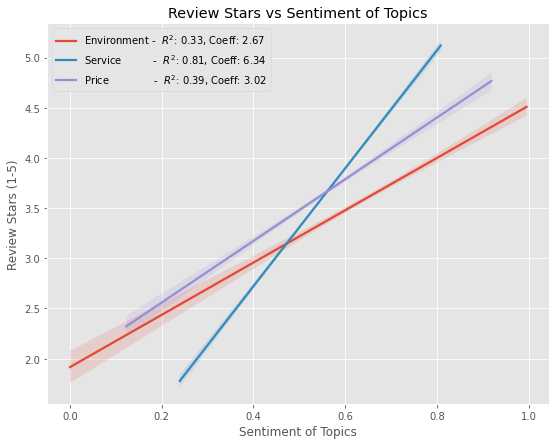

In [30]:
from sklearn.linear_model import LinearRegression

env = review_aggregated[['Env','review_stars']]
env = env[~env['Env'].isna()]

env_reg = LinearRegression()
env_reg.fit(np.array(env['Env']).reshape(-1,1), env['review_stars'])
env_reg.score(np.array(env['Env']).reshape(-1,1), env['review_stars'])
env_reg.coef_

serv = review_aggregated[['Serv','review_stars']]
serv = serv[~serv['Serv'].isna()]

serv_reg = LinearRegression()
serv_reg.fit(np.array(serv['Serv']).reshape(-1,1), serv['review_stars'])
serv_reg.score(np.array(serv['Serv']).reshape(-1,1), serv['review_stars'])
serv_reg.coef_

Pr = review_aggregated[['Pr','review_stars']]
Pr = Pr[~Pr['Pr'].isna()]

Pr_reg = LinearRegression()
Pr_reg.fit(np.array(Pr['Pr']).reshape(-1,1), Pr['review_stars'])
Pr_reg.score(np.array(Pr['Pr']).reshape(-1,1), Pr['review_stars'])
Pr_reg.coef_

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (9,7))
plt.style.use('ggplot')
sns.regplot(x = env['Env'], y =  env['review_stars'], scatter = False)
sns.regplot(x = serv['Serv'], y =  serv['review_stars'], scatter = False)
sns.regplot(x = Pr['Pr'], y =  Pr['review_stars'], scatter = False)
plt.title('Review Stars vs Sentiment of Topics')
plt.xlabel('Sentiment of Topics')
plt.ylabel('Review Stars (1-5)')
plt.legend(['Environment -  $R^{2}$: 0.33, Coeff: 2.67', 'Service          -  $R^{2}$: 0.81, Coeff: 6.34','Price              -  $R^{2}$: 0.39, Coeff: 3.02'])
plt.savefig('plt.png', dpi=300)